# Data-Driven Insights: Uncovering Patterns in Richmond Gas Prices

by Jill Lau

# I. Introduction

__Project Overview:__
This project aims to analyze gas price data in Richmond, BC, to identify key factors influencing price fluctuations. The analysis will explore temporal patterns, location-based variations, and potential correlations with other variables. The findings seek to provide insights into price dynamics and potentially inform strategies for finding cost-effective fuel options.

__Motivation:__
As a resident of Richmond, BC, I'm interested in understanding the factors that drive local gas prices. This project allows me to apply my data analysis skills to a real-world problem with direct relevance to my community. Furthermore, this analysis provides an opportunity to showcase my proficiency in Python, data manipulation, and statistical modeling.

__Data Source:__
The data for this analysis is sourced from [Specify your data source, e.g., GasBuddy, or a combination of sources]. The dataset comprises historical gas prices, location information, and timestamps.

# II. Data Acquisition and Loading

In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import gspread
from oauth2client.service_account import ServiceAccountCredentials


In [40]:
# --- Data Acquisition and Loading ---
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("gs_credentials_jill.json", scope)
client = gspread.authorize(creds)
sheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1ef0ZQvEMclAGdH7jBUOGn9994Xu0OqQOZlj0haSiIy4/edit?gid=428412986#gid=428412986")
GasPrices = sheet.worksheet("GasPrices")
StationIDs = sheet.worksheet("StationIDs")
data1 = GasPrices.get_all_values()
data2 = StationIDs.get_all_values()
df1 = pd.DataFrame(data1[1:], columns=data1[0])
df2 = pd.DataFrame(data2[1:], columns=data2[0])
merged_df = pd.merge(df1, df2, on='Station ID', how='left')

In [41]:
# --- Data Cleaning and Preparation ---
def clean_regular_price_with_null(series):
    """Clean 'Regular Price' by removing '¢' and converting to float."""
    return pd.to_numeric(series.str.replace('¢', '', regex=False), errors='coerce')

def add_time_features(df, timestamp_col='Timestamp'):
    """Add time-related features to the DataFrame."""
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df['Hour'] = df[timestamp_col].dt.hour
    df['Day of Week'] = df[timestamp_col].dt.day_name()
    df['Time Period'] = df['Hour'].apply(lambda h: 'Morning' if 6 <= h < 12 else 'Afternoon' if 12 <= h < 18 else 'Evening' if 18 <= h < 24 else 'Night')
    df['Weekday'] = df[timestamp_col].dt.weekday
    df['Date'] = df[timestamp_col].dt.date
    return df

def add_average_price_columns(df, price_col='Reg price', timestamp_col='Timestamp'):
    """Add average price columns for same day and same day-hour."""
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce').dt.tz_localize('America/Vancouver', ambiguous='infer', nonexistent='shift_forward')
    df['Date'] = df[timestamp_col].dt.date
    df['Hour'] = df[timestamp_col].dt.hour
    df['Avg Price Same Day'] = df.groupby('Date')[price_col].transform('mean')
    df['Avg Price Same Day Hour'] = df.groupby(['Date', 'Hour'])[price_col].transform('mean')
    return df

merged_df['Reg price'] = clean_regular_price_with_null(merged_df['Regular Price'])
merged_df = add_time_features(merged_df)
merged_df = add_average_price_columns(merged_df)

# III. Exploratory Data Analysis (EDA)

In [ ]:
# --- Categorizing the Data ---
# Station Price Category (by individual station across all areas)
merged_df['diff_location'] = merged_df['Reg price'] - merged_df['Avg Price Same Day Hour']
station_diff = merged_df.groupby('Station ID')['diff_location'].mean().reset_index()
station_diff.columns = ['Station ID', 'D_s']
quantiles = station_diff['D_s'].quantile([0.33, 0.66]).values
station_diff['Station Price Category'] = pd.cut(station_diff['D_s'], bins=[-float('inf'), quantiles[0], quantiles[1], float('inf')], labels=['low', 'mid', 'high'], include_lowest=True)
merged_df = merged_df.merge(station_diff[['Station ID', 'Station Price Category']], on='Station ID', how='left')

# Station Price Category by Area (categorize stations within each area)
station_area_diff = merged_df.groupby(['Station ID', 'Area'])['diff_location'].mean().reset_index()
station_area_diff.columns = ['Station ID', 'Area', 'D_s_area']

# Compute quantiles within each area and categorize (broken into steps to avoid downcasting issue)
def categorize_within_area(group):
    quantiles = group['D_s_area'].quantile([0.33, 0.66]).values
    bins = [-float('inf')] + list(quantiles) + [float('inf')]
    return pd.cut(group['D_s_area'], bins=bins, labels=['low', 'mid', 'high'], include_lowest=True)

station_area_diff['Station Price Category by Area'] = station_area_diff.groupby('Area').apply(categorize_within_area).reset_index(drop=True)
merged_df = merged_df.merge(station_area_diff[['Station ID', 'Area', 'Station Price Category by Area']], on=['Station ID', 'Area'], how='left')

# Time Price Category
merged_df['diff_time'] = merged_df['Reg price'] - merged_df['Avg Price Same Day']
time_period_diff = merged_df.groupby('Time Period')['diff_time'].mean().reset_index()
time_period_diff.columns = ['Time Period', 'D_p']
time_period_diff = time_period_diff.sort_values('D_p')
time_period_diff['Time Price Category'] = ['low', 'mid', 'mid', 'high']  # Based on ranking
merged_df = merged_df.merge(time_period_diff[['Time Period', 'Time Price Category']], on='Time Period', how='left')
merged_df['Time Price Category'] = pd.Categorical(merged_df['Time Price Category'], categories=['low', 'mid', 'high'], ordered=True)


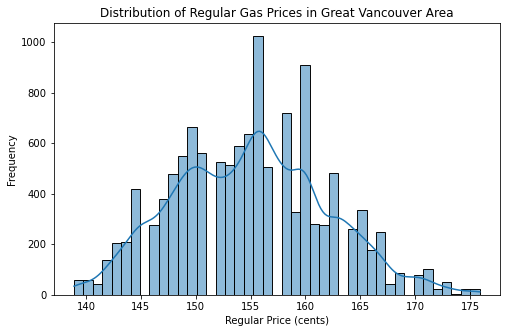

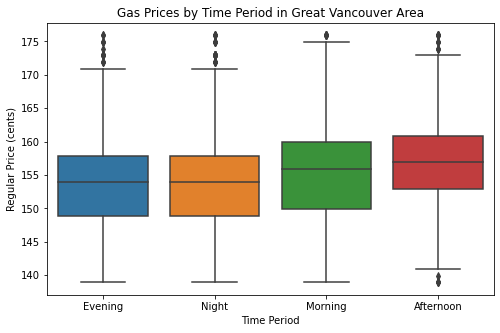

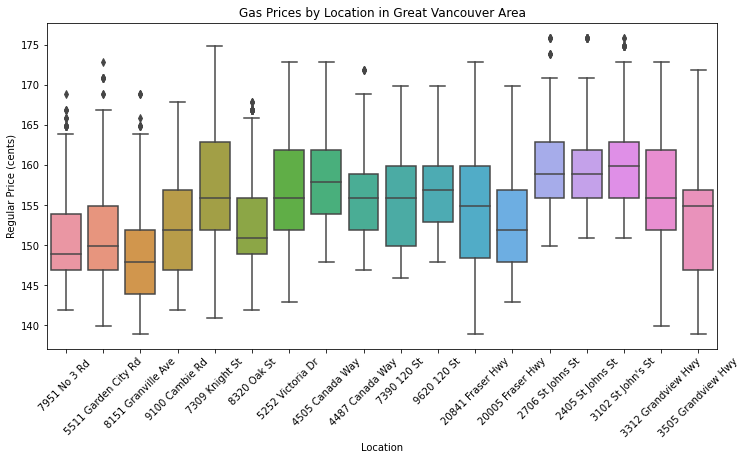

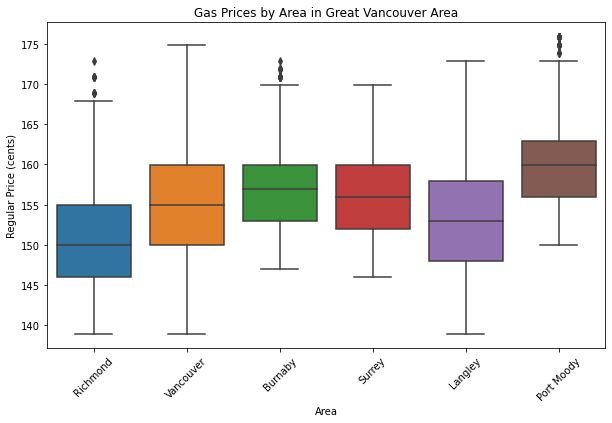

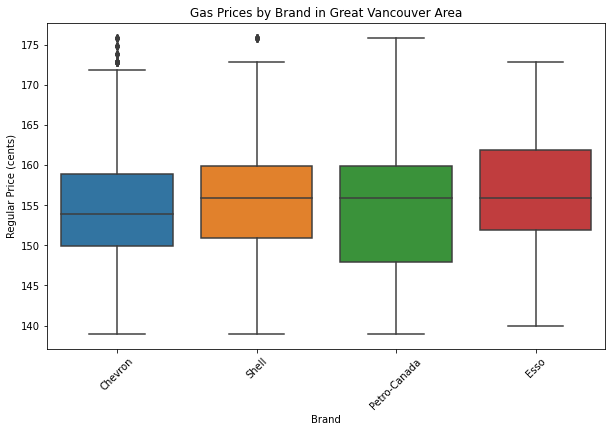

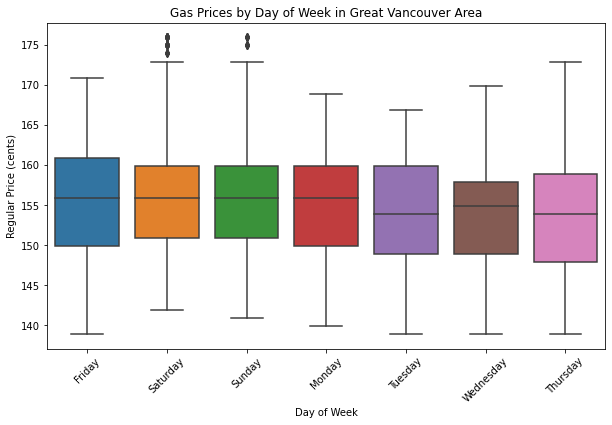

In [44]:
# Histogram of gas prices
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['Reg price'], kde=True)
plt.title('Distribution of Regular Gas Prices in Great Vancouver Area')
plt.xlabel('Regular Price (cents)')
plt.ylabel('Frequency')
plt.show()

# Box plot of prices by Time Period
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='Time Period', y='Reg price')
plt.title('Gas Prices by Time Period in Great Vancouver Area')
plt.xlabel('Time Period')
plt.ylabel('Regular Price (cents)')
#plt.savefig('prices_by_time_period.png')
plt.show()

# Box plot of prices by Location
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Location', y='Reg price')
plt.title('Gas Prices by Location in Great Vancouver Area')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylabel('Regular Price (cents)')
#plt.savefig('prices_by_location.png')
plt.show()

# Box plot of prices by Area
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Area', y='Reg price')
plt.title('Gas Prices by Area in Great Vancouver Area')
plt.xlabel('Area')
plt.xticks(rotation=45)
plt.ylabel('Regular Price (cents)')
#plt.savefig('prices_by_area.png')
plt.show()

# Box plot of prices by Brand
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Brand', y='Reg price')
plt.title('Gas Prices by Brand in Great Vancouver Area')
plt.xlabel('Brand')
plt.xticks(rotation=45)
plt.ylabel('Regular Price (cents)')
#plt.savefig('prices_by_brand.png')
plt.show()

# Box plot of prices by Day of Week
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Day of Week', y='Reg price')
plt.title('Gas Prices by Day of Week in Great Vancouver Area')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Regular Price (cents)')
#plt.savefig('prices_by_weekday.png')
plt.show()

# Contingency table and Chi-Square test (Station Price Category vs Time Price Category)
contingency_table = pd.crosstab(merged_df['Station Price Category'], merged_df['Time Price Category'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test (Station Price Category vs Time Price Category): Chi2 Statistic = {chi2}, p-value = {p}")

# Contingency table and Chi-Square test (Area Price Category vs Time Price Category)
contingency_table_area = pd.crosstab(merged_df['Area Price Category'], merged_df['Time Price Category'])
chi2_area, p_area, _, _ = chi2_contingency(contingency_table_area)
print(f"Chi-Square Test (Area Price Category vs Time Price Category): Chi2 Statistic = {chi2_area}, p-value = {p_area}")

# Contingency table and Chi-Square test (Brand Price Category vs Time Price Category)
contingency_table_brand = pd.crosstab(merged_df['Brand Price Category'], merged_df['Time Price Category'])
chi2_brand, p_brand, _, _ = chi2_contingency(contingency_table_brand)
print(f"Chi-Square Test (Brand Price Category vs Time Price Category): Chi2 Statistic = {chi2_brand}, p-value = {p_brand}")

# Contingency table and Chi-Square test (Weekday Price Category vs Area Price Category)
contingency_table_weekday = pd.crosstab(merged_df['Weekday Price Category'], merged_df['Area Price Category'])
chi2_weekday, p_weekday, _, _ = chi2_contingency(contingency_table_weekday)
print(f"Chi-Square Test (Weekday Price Category vs Area Price Category): Chi2 Statistic = {chi2_weekday}, p-value = {p_weekday}")

# Correlation between encoded categories
merged_df['Station Price Code'] = merged_df['Station Price Category'].cat.codes
merged_df['Area Price Code'] = merged_df['Area Price Category'].cat.codes
merged_df['Brand Price Code'] = merged_df['Brand Price Category'].cat.codes
merged_df['Weekday Price Code'] = merged_df['Weekday Price Category'].cat.codes
merged_df['Time Price Code'] = merged_df['Time Price Category'].cat.codes
correlation = merged_df[['Station Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_area = merged_df[['Area Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_brand = merged_df[['Brand Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_weekday = merged_df[['Weekday Price Code', 'Area Price Code']].corr().iloc[0, 1]
print(f"Correlation between Station Price Category and Time Price Category: {correlation}")
print(f"Correlation between Area Price Category and Time Price Category: {correlation_area}")
print(f"Correlation between Brand Price Category and Time Price Category: {correlation_brand}")
print(f"Correlation between Weekday Price Category and Area Price Category: {correlation_weekday}")


In [19]:
# --- Analyzing Relationships ---

In [45]:
# Contingency table and Chi-Square test (Station Price Category vs Time Price Category)
contingency_table = pd.crosstab(merged_df['Station Price Category'], merged_df['Time Price Category'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test (Station Price Category vs Time Price Category): Chi2 Statistic = {chi2}, p-value = {p}")

# Contingency table and Chi-Square test (Area Price Category vs Time Price Category)
contingency_table_area = pd.crosstab(merged_df['Area Price Category'], merged_df['Time Price Category'])
chi2_area, p_area, _, _ = chi2_contingency(contingency_table_area)
print(f"Chi-Square Test (Area Price Category vs Time Price Category): Chi2 Statistic = {chi2_area}, p-value = {p_area}")

# Contingency table and Chi-Square test (Brand Price Category vs Time Price Category)
contingency_table_brand = pd.crosstab(merged_df['Brand Price Category'], merged_df['Time Price Category'])
chi2_brand, p_brand, _, _ = chi2_contingency(contingency_table_brand)
print(f"Chi-Square Test (Brand Price Category vs Time Price Category): Chi2 Statistic = {chi2_brand}, p-value = {p_brand}")

# Contingency table and Chi-Square test (Weekday Price Category vs Area Price Category)
contingency_table_weekday = pd.crosstab(merged_df['Weekday Price Category'], merged_df['Area Price Category'])
chi2_weekday, p_weekday, _, _ = chi2_contingency(contingency_table_weekday)
print(f"Chi-Square Test (Weekday Price Category vs Area Price Category): Chi2 Statistic = {chi2_weekday}, p-value = {p_weekday}")

# Correlation between encoded categories
merged_df['Station Price Code'] = merged_df['Station Price Category'].cat.codes
merged_df['Area Price Code'] = merged_df['Area Price Category'].cat.codes
merged_df['Brand Price Code'] = merged_df['Brand Price Category'].cat.codes
merged_df['Weekday Price Code'] = merged_df['Weekday Price Category'].cat.codes
merged_df['Time Price Code'] = merged_df['Time Price Category'].cat.codes
correlation = merged_df[['Station Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_area = merged_df[['Area Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_brand = merged_df[['Brand Price Code', 'Time Price Code']].corr().iloc[0, 1]
correlation_weekday = merged_df[['Weekday Price Code', 'Area Price Code']].corr().iloc[0, 1]
print(f"Correlation between Station Price Category and Time Price Category: {correlation}")
print(f"Correlation between Area Price Category and Time Price Category: {correlation_area}")
print(f"Correlation between Brand Price Category and Time Price Category: {correlation_brand}")
print(f"Correlation between Weekday Price Category and Area Price Category: {correlation_weekday}")


Chi-Square Test (Station Price Category vs Time Price Category): Chi2 Statistic = 0.0, p-value = 1.0
Chi-Square Test (Area Price Category vs Time Price Category): Chi2 Statistic = 0.0, p-value = 1.0
Chi-Square Test (Brand Price Category vs Time Price Category): Chi2 Statistic = 0.0, p-value = 1.0
Chi-Square Test (Weekday Price Category vs Area Price Category): Chi2 Statistic = 0.0, p-value = 1.0
Correlation between Station Price Category and Time Price Category: -2.996725295628699e-20
Correlation between Area Price Category and Time Price Category: 2.2220175209803856e-17
Correlation between Brand Price Category and Time Price Category: -2.86667700955888e-17
Correlation between Weekday Price Category and Area Price Category: 2.3060635550128893e-17


In [ ]:
# Drop rows with NaN in Reg price to avoid issues in ANOVA
merged_df = merged_df.dropna(subset=['Reg price'])

# --- Debugging: Check Data Integrity ---
print("\nData Integrity Check:")
print(f"Total rows after merge: {len(merged_df)}")
print(f"Unique Areas: {merged_df['Area'].nunique()} ({merged_df['Area'].unique()})")
print(f"Unique Brands: {merged_df['Brand'].nunique()} ({merged_df['Brand'].unique()})")
print(f"Unique Days of Week: {merged_df['Day of Week'].nunique()} ({merged_df['Day of Week'].unique()})")
print(f"Unique Hours: {merged_df['Hour'].nunique()} ({sorted(merged_df['Hour'].unique())})")
print(f"Rows with NaN in Reg price: {(merged_df['Reg price'].isna().sum())}")

# Check for sparse combinations
print("\nCross-Tabulation of Area and Hour:")
print(pd.crosstab(merged_df['Area'], merged_df['Hour']))

In [55]:
# --- Analyzing Relationships ---
# One-Way ANOVA for Reg price across Areas
model_area = ols('Q("Reg price") ~ C(Area)', data=merged_df).fit()
anova_table_area = sm.stats.anova_lm(model_area, typ=2)
print("\nOne-Way ANOVA for Area:")
print(anova_table_area)

# Post-Hoc Test (Tukey's HSD) for Area
tukey_area = pairwise_tukeyhsd(endog=merged_df['Reg price'], groups=merged_df['Area'], alpha=0.05)
print("\nTukey HSD Test for Area:")
print(tukey_area)

# One-Way ANOVA for Reg price across Brands
model_brand = ols('Q("Reg price") ~ C(Brand)', data=merged_df).fit()
anova_table_brand = sm.stats.anova_lm(model_brand, typ=2)
print("\nOne-Way ANOVA for Brand:")
print(anova_table_brand)

# Post-Hoc Test (Tukey's HSD) for Brand
tukey_brand = pairwise_tukeyhsd(endog=merged_df['Reg price'], groups=merged_df['Brand'], alpha=0.05)
print("\nTukey HSD Test for Brand:")
print(tukey_brand)

# One-Way ANOVA for Reg price across Day of Week
model_weekday = ols('Q("Reg price") ~ C(Q("Day of Week"))', data=merged_df).fit()
anova_table_weekday = sm.stats.anova_lm(model_weekday, typ=2)
print("\nOne-Way ANOVA for Day of Week:")
print(anova_table_weekday)

# Post-Hoc Test (Tukey's HSD) for Day of Week
tukey_weekday = pairwise_tukeyhsd(endog=merged_df['Reg price'], groups=merged_df['Day of Week'], alpha=0.05)
print("\nTukey HSD Test for Day of Week:")
print(tukey_weekday)

# One-Way ANOVA for Reg price across Hours
model_hour = ols('Q("Reg price") ~ C(Hour)', data=merged_df).fit()
anova_table_hour = sm.stats.anova_lm(model_hour, typ=2)
print("\nOne-Way ANOVA for Hour:")
print(anova_table_hour)

# Post-Hoc Test (Tukey's HSD) for Hour
tukey_hour = pairwise_tukeyhsd(endog=merged_df['Reg price'], groups=merged_df['Hour'].astype(str), alpha=0.05)
print("\nTukey HSD Test for Hour:")
print(tukey_hour)

# Two-Way ANOVA for Area and Hour (Main Effects Only)
model_area_hour = ols('Q("Reg price") ~ C(Area) + C(Hour)', data=merged_df).fit()
anova_table_area_hour = sm.stats.anova_lm(model_area_hour, typ=2)
print("\nTwo-Way ANOVA for Area and Hour (Main Effects Only):")
print(anova_table_area_hour)

# Two-Way ANOVA for Day of Week and Hour (Main Effects Only)
model_weekday_hour = ols('Q("Reg price") ~ C(Q("Day of Week")) + C(Hour)', data=merged_df).fit()
anova_table_weekday_hour = sm.stats.anova_lm(model_weekday_hour, typ=2)
print("\nTwo-Way ANOVA for Day of Week and Hour (Main Effects Only):")
print(anova_table_weekday_hour)


One-Way ANOVA for Area:
                 sum_sq       df          F  PR(>F)
C(Area)   107486.743221      5.0  543.16158     0.0
Residual  485624.310334  12270.0        NaN     NaN

Tukey HSD Test for Area:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
   Burnaby    Langley  -3.4908  0.001  -4.177 -2.8046   True
   Burnaby Port Moody    2.671  0.001  2.0442  3.2977   True
   Burnaby   Richmond  -6.3785  0.001  -6.973  -5.784   True
   Burnaby     Surrey  -0.7566 0.0209 -1.4431 -0.0702   True
   Burnaby  Vancouver  -1.9506  0.001 -2.5249 -1.3763   True
   Langley Port Moody   6.1618  0.001  5.5352  6.7884   True
   Langley   Richmond  -2.8877  0.001  -3.482 -2.2933   True
   Langley     Surrey   2.7342  0.001  2.0479  3.4205   True
   Langley  Vancouver   1.5402  0.001  0.9661  2.1144   True
Port Moody   Richmond  -9.0495  0.001  -9.574 -8.5249   True


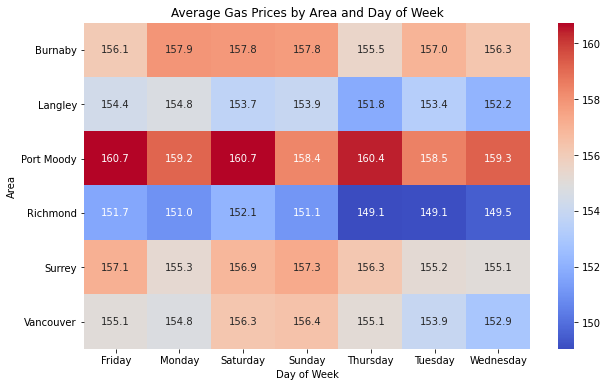

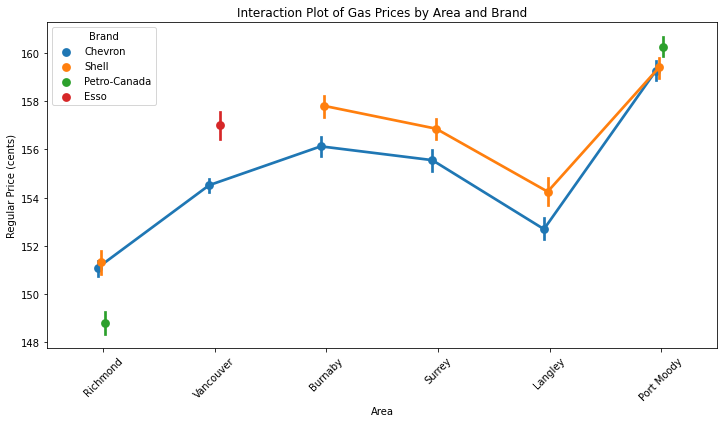

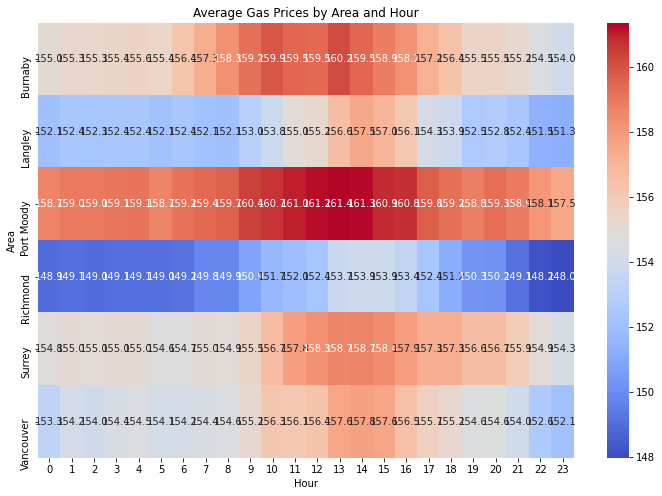

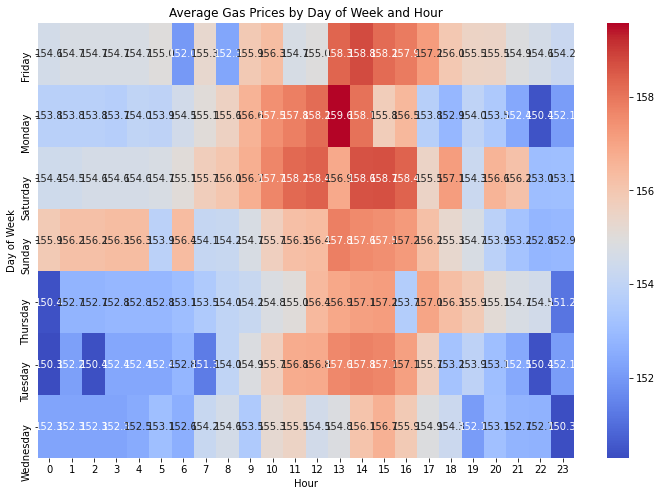

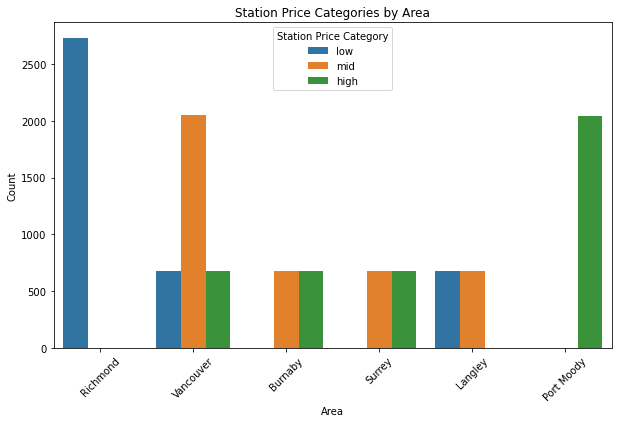

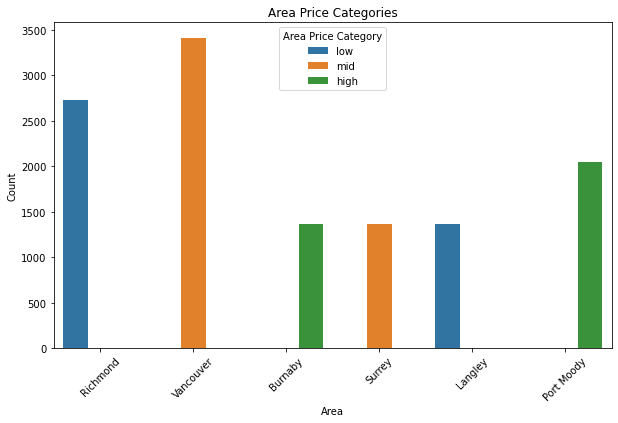

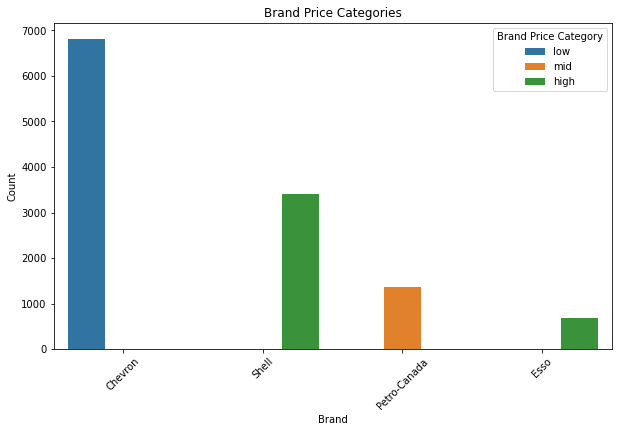

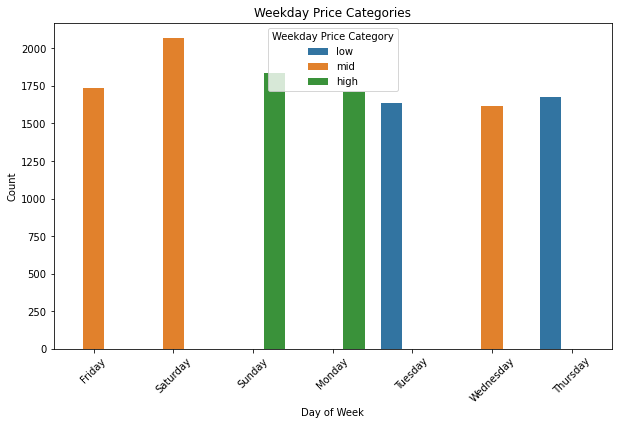

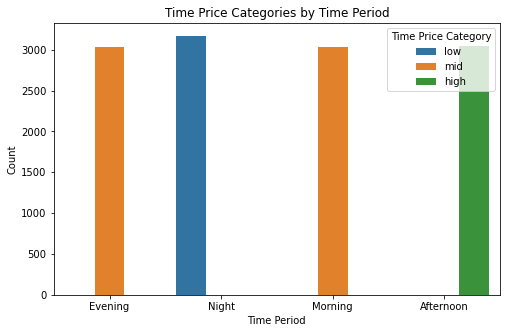

In [56]:
# Visualization: Heatmap of average prices by Area and Day of Week
pivot_area_weekday = merged_df.pivot_table(values='Reg price', index='Area', columns='Day of Week', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_area_weekday, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Average Gas Prices by Area and Day of Week')
#plt.savefig('heatmap_area_weekday.png')
plt.show()

# Visualization: Interaction Plot for Area and Brand
plt.figure(figsize=(12, 6))
sns.pointplot(data=merged_df, x='Area', y='Reg price', hue='Brand', dodge=True)
plt.title('Interaction Plot of Gas Prices by Area and Brand')
plt.xticks(rotation=45)
plt.ylabel('Regular Price (cents)')
#plt.savefig('interaction_area_brand.png')
plt.show()

# Visualization: Heatmap of average prices by Area and Hour
pivot_area_hour = merged_df.pivot_table(values='Reg price', index='Area', columns='Hour', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_area_hour, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Average Gas Prices by Area and Hour')
#plt.savefig('heatmap_area_hour.png')
plt.show()

# Visualization: Heatmap of average prices by Day of Week and Hour
pivot_weekday_hour = merged_df.pivot_table(values='Reg price', index='Day of Week', columns='Hour', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_weekday_hour, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Average Gas Prices by Day of Week and Hour')
#plt.savefig('heatmap_weekday_hour.png')
plt.show()

# Bar plot of Station Price Categories by Area
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Area', hue='Station Price Category')
plt.title('Station Price Categories by Area')
plt.xlabel('Area')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.savefig('station_categories_by_area.png')
plt.show()

# Bar plot of Area Price Categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Area', hue='Area Price Category')
plt.title('Area Price Categories')
plt.xlabel('Area')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.savefig('area_categories.png')
plt.show()

# Bar plot of Brand Price Categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Brand', hue='Brand Price Category')
plt.title('Brand Price Categories')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.savefig('brand_categories.png')
plt.show()

# Bar plot of Weekday Price Categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Day of Week', hue='Weekday Price Category')
plt.title('Weekday Price Categories')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.savefig('weekday_categories.png')
plt.show()

# Bar plot of Time Price Categories by Time Period
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='Time Period', hue='Time Price Category')
plt.title('Time Price Categories by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Count')
#plt.savefig('time_categories_by_period.png')
plt.show()

In [47]:
# --- Summary Statistics ---
print("\nSummary Statistics by Area:")
print(merged_df.groupby('Area')['Reg price'].describe())
print("\nSummary Statistics by Brand:")
print(merged_df.groupby('Brand')['Reg price'].describe())
print("\nSummary Statistics by Day of Week:")
print(merged_df.groupby('Day of Week')['Reg price'].describe())


Summary Statistics by Area:
             count        mean       std    min    25%    50%    75%    max
Area                                                                       
Burnaby     1365.0  156.963736  5.652411  146.9  152.9  156.9  159.9  172.9
Langley     1366.0  153.472914  6.804420  138.9  147.9  152.9  157.9  172.9
Port Moody  2044.0  159.634687  5.410950  149.9  155.9  159.9  162.9  175.9
Richmond    2727.0  150.585222  6.132278  138.9  145.9  149.9  154.9  172.9
Surrey      1364.0  156.207111  5.494901  145.9  151.9  155.9  159.9  169.9
Vancouver   3410.0  155.013138  7.172278  138.9  149.9  154.9  159.9  174.9

Summary Statistics by Brand:
               count        mean       std    min    25%    50%    75%    max
Brand                                                                        
Chevron       6821.0  154.384885  6.649276  138.9  149.9  153.9  158.9  175.9
Esso           682.0  156.998240  7.374244  139.9  151.9  155.9  161.9  172.9
Petro-Canada  1364.0 